In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import glob
import cartopy.crs as ccrs
import cmocean

In [3]:
path_1_10 = '/glade/scratch/bachman/Machine_Learning/MOM6/1_10/'
path_ml_eke = '/glade/work/ashao/ML_EKE'
path_control = '/glade/scratch/gmarques/for_ashao'
files_1_10 = glob.glob(f'{path_1_10}/INPUT_DATA*cf2*020*.nc')
data = {}

In [4]:
grid = dict(OM4_025=xr.open_dataset('/glade/work/ashao/ocean_static.OM4_025.nc'))
grid['1_10'] = xr.open_dataset('/glade/scratch/gmarques/for_ashao/g.c2b6.GJRA.TL319_t13.control_mct.003.mom6.static.nc').load()

In [5]:
data['1_10'] = xr.concat([xr.open_dataset(file)[['EKE_sfc','Rd_dx_z']] for file in files_1_10],'time').rename( {'Rd_dx_z':'Rd_dx' }).mean('time')

In [6]:
data['control'] = xr.concat([xr.open_dataset( f'{path_control}/{year}0101.ocean_annual.nc')[['MEKE','Rd_dx']].mean('time') for year in [1978]],'time').load()

In [7]:
data['ML_EKE'] = xr.concat([xr.open_dataset(f'{path_ml_eke}/MOM_{ensemble}/19210101.ocean_annual_sfc_2.nc')['MEKE'] for ensemble in range(12)],'ensemble')

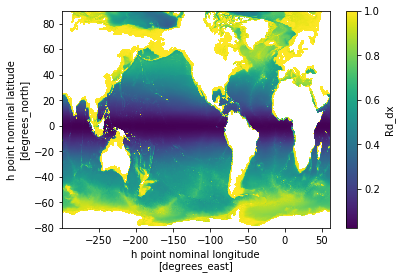

In [15]:
OM4_025_scaling = (1/(1+data['control']['Rd_dx']**2))
ER_scaling = (1/(1+data['1_10']['Rd_dx']**2)).rename({'y':'yh','x':'xh'})
OM4_025_scaling.plot()

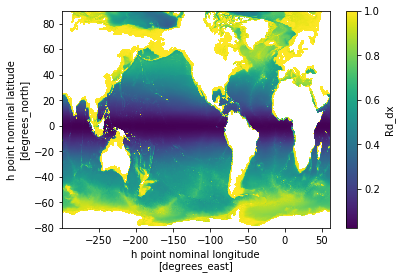

In [9]:
OM4_025_scaling.plot()

In [10]:
wt_025 = grid['OM4_025'].area_t*grid['OM4_025'].wet
norm_025 = wt_025.sum('xh').squeeze()

In [11]:
wt_0010 = (grid['1_10'].area_t.isel(xh=slice(None,None,2),yh=slice(6,None,2))*grid['1_10'].wet.isel(xh=slice(None,None,2),yh=slice(6,None,2)))
norm_0010 = wt_0010.sum('xh').squeeze()

In [12]:
wt_0010*ER_scaling.values

<xarray.DataArray (yh: 1197, xh: 1800)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * xh       (xh) float64 -109.9 -109.8 -109.6 -109.3 ... -110.6 -110.3 -110.2
  * yh       (yh) float64 -78.22 -78.13 -78.05 -77.97 ... 89.73 89.83 89.92

/glade/work/ashao/miniconda3/envs/analysis/lib/python3.7/site-packages/xarray/core/computation.py:733: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


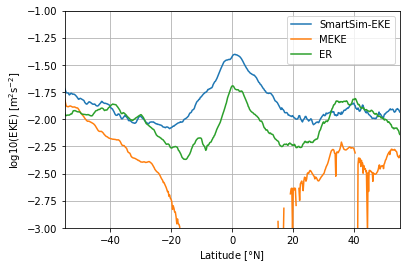

In [20]:
ML_EKE_zonavg = ((data['ML_EKE'].mean(['time','ensemble'])*wt_025).sum('xh')/norm_025)
plt.plot(grid['OM4_025'].geolat.mean('xh'),np.log10(ML_EKE_zonavg),label='SmartSim-EKE')
control_EKE_zonavg = ((data['control']['MEKE'].mean(['time'])*wt_025).sum('xh')/norm_025)
plt.plot(grid['OM4_025'].geolat.mean('xh'),np.log10(control_EKE_zonavg),label='MEKE')
ER_EKE_zonavg = ((data['1_10']['EKE_sfc']*wt_0010.data).sum('x')/norm_0010.data)
plt.plot(data['1_10'].y,np.log10(ER_EKE_zonavg),label='ER')
plt.legend()
plt.xlim([-55,55])
plt.ylim([-3,-1])
plt.xlabel('Latitude [$\degree$N]')
plt.ylabel('log10(EKE) [m$^2$s$^{-2}$]')
plt.grid()

/glade/work/ashao/miniconda3/envs/analysis/lib/python3.7/site-packages/xarray/core/computation.py:733: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


Text(0, 0.5, 'log10(EKE) [m$^2$s$^{-2}$]')

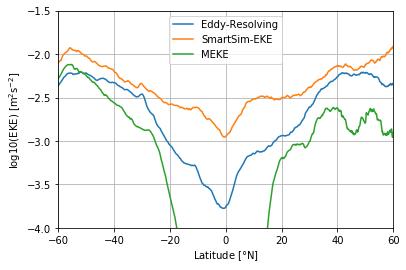

In [16]:
plt.plot(data['1_10'].y, np.log10(data['1_10']['EKE_sfc']*ER_scaling.data).mean('x'),label='Eddy-Resolving')
plt.plot(grid['OM4_025'].geolat.mean('xh'),np.log10(data['ML_EKE'].mean(['time','ensemble'])*OM4_025_scaling).mean('xh'),label='SmartSim-EKE')
plt.plot(grid['OM4_025'].geolat.mean('xh'),np.log10(data['control']['MEKE']*OM4_025_scaling).mean(['xh']).squeeze(),label='MEKE')

# plt.plot(data['1_10'].y, np.log10(data['1_10']['EKE_sfc']).mean('x'),label='Eddy-Resolving')
# plt.plot(grid['OM4_025'].geolat.mean('xh'),np.log10(data['ML_EKE'].mean(['time','ensemble'])).mean('xh'),label='SmartSim-EKE')
# plt.plot(grid['OM4_025'].geolat.mean('xh'),np.log10(data['control']['MEKE']).mean(['xh']).squeeze(),label='MEKE')

plt.xlim([-60,60])
plt.ylim([-4,-1.5])
plt.grid()
plt.legend()
plt.xlabel('Latitude [$\degree$N]')
plt.ylabel('log10(EKE) [m$^2$s$^{-2}$]')

Text(0.5, 1.0, 'MEKE\n1/4$\\degree$')

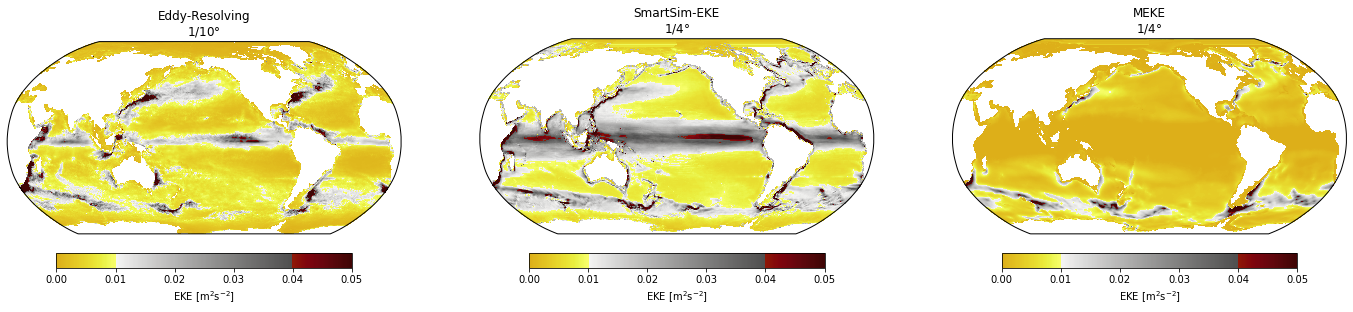

In [50]:
pc_args = dict(vmin=0,vmax=0.05,transform=ccrs.PlateCarree(),cmap=cmocean.cm.oxy_r)
cbar_args = dict(orientation='horizontal',shrink=0.75,pad=0.02,label='EKE [m$^2$s$^{-2}$]')

lon_er = grid['1_10'].geolon.isel(xh=slice(None,None,2),yh=slice(6,None,2))
lat_er = grid['1_10'].geolat.isel(xh=slice(None,None,2),yh=slice(6,None,2))

plt.figure(figsize=(24,18))
plt.subplot(1,3,1, projection=ccrs.Robinson(central_longitude=200))
plt.pcolormesh(lon_er,lat_er,(data['1_10']['EKE_sfc']).squeeze(),**pc_args)
plt.colorbar(**cbar_args)
plt.title('Eddy-Resolving\n1/10$\degree$')

plt.subplot(1,3,2, projection=ccrs.Robinson(central_longitude=200))
plt.pcolormesh(grid['OM4_025'].geolon,grid['OM4_025'].geolat,(data['ML_EKE'].mean(['time','ensemble'])).squeeze(),**pc_args)
plt.colorbar(**cbar_args)
plt.title('SmartSim-EKE\n1/4$\degree$')

plt.subplot(1,3,3, projection=ccrs.Robinson(central_longitude=200))
plt.pcolormesh(grid['OM4_025'].geolon,grid['OM4_025'].geolat,(data['control']['MEKE']).squeeze(),**pc_args)
plt.colorbar(**cbar_args)
plt.title('MEKE\n1/4$\degree$')

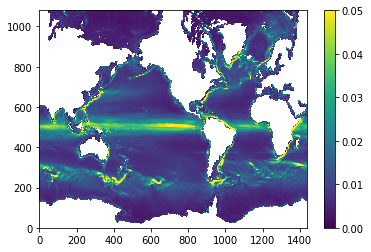

In [188]:
plt.pcolormesh((data['ML_EKE'].mean(['time','ensemble'])).squeeze(),vmin=0,vmax=0.05)
plt.colorbar()

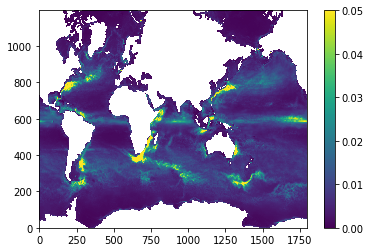

In [187]:
plt.pcolormesh(((data['1_10']['EKE_sfc']).squeeze()),vmin=0,vmax=0.05)
plt.colorbar()

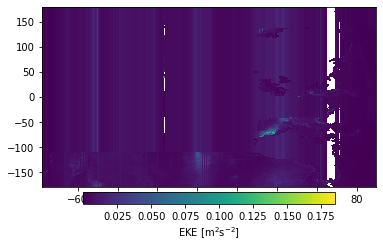

In [206]:
plt.pcolormesh(lon_er,lat_er,(data['1_10']['EKE_sfc']).squeeze())
plt.colorbar(**cbar_args)

In [28]:
lat_intp = np.linspace(-60,60,1200)
lat_om4  = grid['OM4_025'].geolat.mean('xh')
lat_er   = data['1_10'].y

ml_eke_interp = np.interp(lat_intp, lat_om4, ML_EKE_zonavg)
control_eke_interp = np.interp(lat_intp, lat_om4, control_EKE_zonavg)
er_eke_interp = np.interp(lat_intp, lat_er, ER_EKE_zonavg)

In [57]:
tropics_mask = np.abs(lat_intp)>=0
# tropics_mask[ tropics_mask ] = np.nan

ml_rms = np.nanmean(np.sqrt(ml_eke_interp**2-er_eke_interp**2)*tropics_mask)
control_rms = np.nanmean(np.sqrt(control_eke_interp**2-er_eke_interp**2)*tropics_mask)

print(f'ML_EKE: {ml_rms}')
print(f'control EKE: {control_rms}')


ML_EKE: 0.012299297431810885
control EKE: 0.015309427230998646


/glade/work/ashao/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.
/glade/work/ashao/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


In [58]:
ml_rms/control_rms

0.8033806390161464